# Анализ A/B теста linearized likes

## Общие данные и цели исследования

Изучение метрики линеаризованных лайков

Имеются данные А/B-теста (группы 1 и 2) с '2023-08-29' по '2023-09-04'. В группе 2 (тестовой) был использован новый алгоритм рекомендации постов. Группа 1 контрольная.
A/B тест проводит с целью определить изменения показателя CTR (увеличения CTR у тестовой группы по сравнению с контрольной)

Так же рассмотрим группы 0 и 3 за тот же период

Результаты A/B теста будем проверять через следующие стат.тесты:

1. t-тест на обычном CTR и на линеаризованных лайках

Стуктура данных
- user_id - уникальный идентификатор пользователя
- post_id - уникальный идентификатор поста
- action - действие (просмотр/лайк)
- time - дата и время действия
- gender - гендер
- age - возраст
- country - страна
- city - город
- os - операционная система
- source - источник откуда пришел пользователь
- exp_group - номер группы тестирования

## Блок общих функций и импорта библиотек

In [2]:
#импорт из стандартной библиотеки
import hashlib as hl

#импорт сторонних библиотек
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st
import pandahouse as ph

Создадим класс для подключения к БД и получения результатов запроса

In [3]:
class getch:
    def __init__(self, query, db=''):
        self.connection = {
            'host': '',
            'password': '',
            'user': '',
            'database': db,
        }
        self.query = query
        self.getchdf

    @property
    def getchdf(self):
        try:
            self.df = ph.read_clickhouse(self.query, connection=self.connection)

        except Exception as err:
            print("\033[31m {}".format(err))
            exit(0)

Создадим функцию для расчета и вывода результатов t-теста

In [4]:
def ttest_start(a_group, b_group, column='ctr', a=0.05, hypotesis='two-sided') -> float:
    p_value = st.ttest_ind(a_group[column], b_group[column], equal_var=False, alternative = hypotesis)[1]
    if p_value <= a:
        print(f'p_value = {p_value}, как следствие мы отклоняем нулевую гипотезу в пользу альтернативной')
    else:
        print(f'p_value = {p_value}, как следствие мы не можем отклонить нулевую гипотезу в пользу альтернативной')
    return None

## Загрузка данных и подготовка их к исследованию

Загрузим первую строку, и посмотрим на структуру

In [5]:
head_of_db = getch('SELECT * FROM {db}.feed_actions limit 1')

In [6]:
head_of_db.df

,user_id,post_id,action,time,gender,age,country,city,os,source,exp_group
0,151307,3596,view,2023-09-20 07:45:26,0,21,Russia,Krasnoyarsk,Android,organic,4


In [7]:
abgroup = getch('''
    SELECT user_id,
    countIf(action='like') as like,
    countIf(action='view') as view,
    exp_group,
    like / view as ctr
    FROM {db}.feed_actions 
    where exp_group between 0 and 3
        and toDate(time) between '2023-08-29' and '2023-09-04'
    group by user_id, exp_group
    ''') 

Посмотрим на общие данные в полученном датафрейме, а так же проверим на полные дубликаты все строчки.

In [8]:
abgroup.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39819 entries, 0 to 39818
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    39819 non-null  uint32 
 1   like       39819 non-null  uint64 
 2   view       39819 non-null  uint64 
 3   exp_group  39819 non-null  int8   
 4   ctr        39819 non-null  float64
dtypes: float64(1), int8(1), uint32(1), uint64(2)
memory usage: 1.1 MB


In [9]:
abgroup.df.duplicated().sum()

0

Посмотрим на количество пользователей в группах

In [10]:
abgroup.df['exp_group'].value_counts()

exp_group
1    10020
3    10002
0     9920
2     9877
Name: count, dtype: int64

In [11]:
ctr_control_3 = abgroup.df.query('exp_group == 3')['like'].sum() / abgroup.df.query('exp_group == 3')['view'].sum()
ctr_control_2 = abgroup.df.query('exp_group == 2')['like'].sum() / abgroup.df.query('exp_group == 2')['view'].sum()

In [12]:
abgroup.df['lin_like'] = (
    abgroup.df['like'] - (
        abgroup.df['exp_group'].map({0: ctr_control_3, 1: ctr_control_2, 2: ctr_control_2, 3: ctr_control_3}) 
        * abgroup.df['view']
    )
)

In [13]:
abgroup.df.sample(10, random_state=100)

,user_id,like,view,exp_group,ctr,lin_like
11141,115345,9,49,3,0.183673,-2.084156
2637,30199,9,78,1,0.115385,-6.619540
30117,108009,5,17,0,0.294118,1.154477
26692,8782,7,80,3,0.087500,-11.096581
38330,135240,33,192,0,0.171875,-10.431793
27890,15403,3,45,2,0.066667,-6.011273
1131,114353,5,31,1,0.161290,-1.207766
14253,33297,26,64,0,0.406250,11.522736
8270,130377,19,160,2,0.118750,-13.040082
27952,123635,11,34,3,0.323529,3.308953


In [14]:
group_0_3 = abgroup.df.query('exp_group == 0 or exp_group == 3')
group_1_2 = abgroup.df.query('exp_group == 1 or exp_group == 2')

Построим распределение по обычному CTR

<Axes: title={'center': 'linearized_like'}, xlabel='lin_like', ylabel='Count'>

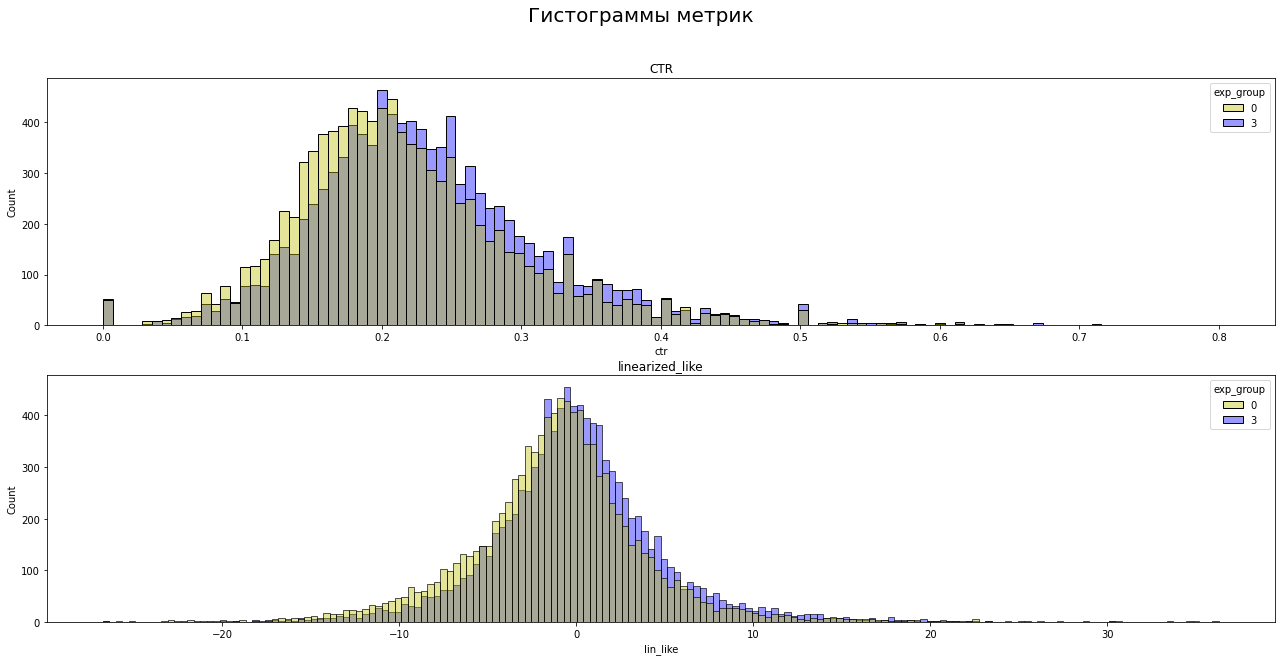

In [21]:
fig, axs = plt.subplots(2,1, figsize=(22,10))
plt.suptitle('Гистограммы метрик групп 0 и 3', fontsize=20)
axs[0].set_title('CTR')
sns.histplot(data = group_0_3, x='ctr', hue='exp_group', palette = ['y', 'b'], alpha = 0.4, ax=axs[0])
axs[1].set_title('linearized_like')
sns.histplot(data = group_0_3, x='lin_like', hue='exp_group', palette = ['y', 'b'], alpha = 0.4, ax=axs[1])
plt.show()

Посмотрим на средние значения метрик

In [77]:
group_0_3.groupby('exp_group')[['lin_like', 'ctr']].mean().round(4)

,lin_like,ctr
exp_group,,
0,-1.1065,0.2169
3,0.0000,0.2332


<Axes: title={'center': 'linearized_like'}, xlabel='lin_like', ylabel='Count'>

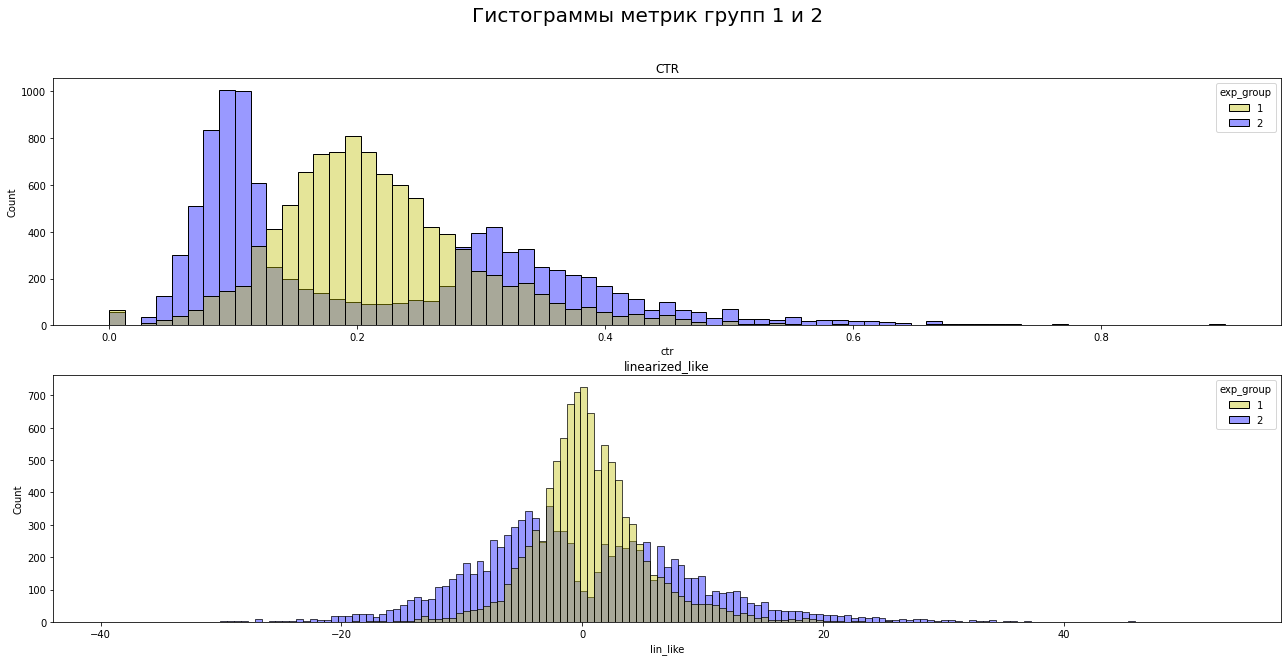

In [22]:
fig, axs = plt.subplots(2,1, figsize=(22,10))
plt.suptitle('Гистограммы метрик групп 1 и 2', fontsize=20)
axs[0].set_title('CTR')
sns.histplot(data = group_1_2, x='ctr', hue='exp_group', palette = ['y', 'b'], alpha = 0.4, ax=axs[0])
axs[1].set_title('linearized_like')
sns.histplot(data = group_1_2, x='lin_like', hue='exp_group', palette = ['y', 'b'], alpha = 0.4, ax=axs[1])
plt.show()

Посмотрим на средние значения метрик

In [66]:
group_1_2.groupby('exp_group')[['lin_like', 'ctr']].mean().round(4)

,lin_like,ctr
exp_group,,
1,0.625,0.2168
2,-0.000,0.2161


Установим уровень значимости и сформируем переменные с группами A и B

In [74]:
a=0.05
a_group_0 = group_0_3.query('exp_group == 0')
b_group_3 = group_0_3.query('exp_group == 3')

a_group_1 = group_1_2.query('exp_group == 1')
b_group_2 = group_1_2.query('exp_group == 2')

## Проведем сравнение с помощью критерия T-теста между группами 0 и 3

Проверим равенство средних t-тестом между всей группой 0 и группой 3
1. H0 - средние между группами равны
2. H1 - средние между группами не равны

a=0.05

In [69]:
ttest_start(a_group_0, b_group_3, 'ctr', a)

p_value = 6.216047483057877e-44, как следствие мы отклоняем нулевую гипотезу в пользу альтернативной


In [70]:
ttest_start(a_group_0, b_group_3, 'lin_like', a)

p_value = 4.788878529845026e-57, как следствие мы отклоняем нулевую гипотезу в пользу альтернативной


## Проведем сравнение с помощью критерия T-теста между группами 1 и 2

Проверим равенство средних t-тестом между всей группой 1 и группой 2
1. H0 - средние между группами равны
2. H1 - средние между группами не равны

a=0.05

In [75]:
ttest_start(a_group_1, b_group_2, 'ctr', a)

p_value = 0.685373331140751, как следствие мы не можем отклонить нулевую гипотезу в пользу альтернативной


In [76]:
ttest_start(a_group_1, b_group_2, 'lin_like', a)

p_value = 2.057830534124001e-09, как следствие мы отклоняем нулевую гипотезу в пользу альтернативной


## ВЫВОД

У группы 0 и 3 различия были зафиксированы и по метрики CTR и по метрики linearized_likes, при этом для второй метрики p-value получился меньше чем для CTR

У группы 1 и 2 t-тест по метрики CTR различий не показал, а вот по метрики linearized_likes были зафиксированы статистически значимые различия.

Так же стоит заметить, что форма распределения (особенно видно у пары групп 1 и 2) меняется у метрики linearized_likes относительно CTR, особенно у пользователей у которых много просмотров но мало лайков. Тем самым она подчеркивает различия сильнее чем CTR (другими словами является более чувствительной), что дает возможность t-тестам увидеть разницу. 